In [1]:
from utils import show_task_activation, create_4d_volume, create_events_df, compute_task_fmap, plot_fmap, processed_event
from utils import subject_gm_mask_path, paradigm_dir

from os.path import join as pjoin
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

import nibabel as nib
from nilearn import image
from nilearn.glm import threshold_stats_img
from nilearn.glm.first_level import FirstLevelModel, run_glm
from nilearn.plotting import (
    plot_design_matrix,
    plot_stat_map,
    plot_img,
    plot_glass_brain,
)

In [2]:
subject = "127630"
task = "MOTOR"
acq = "RL"
smoothing = 10
TR = 0.72 

selecting subject gray matter mask
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/127630_gm_mask.nii.gz
concatenating volumes for task MOTOR
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/127630_MOTOR_RL_smooth-10mm_fMRIvols.nii.gz
files 127630_MOTOR_RL_smooth-10mm_fMRIvols.nii.gz already exists, skipping processing
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/127630_Regressor_tfMRI_MOTOR_RL.mat
/media/RCPNAS/Data2/CS-433-ML4S/data/events/127630_MOTOR_RL_event.csv
fitting GLM for task MOTOR
computing fmap


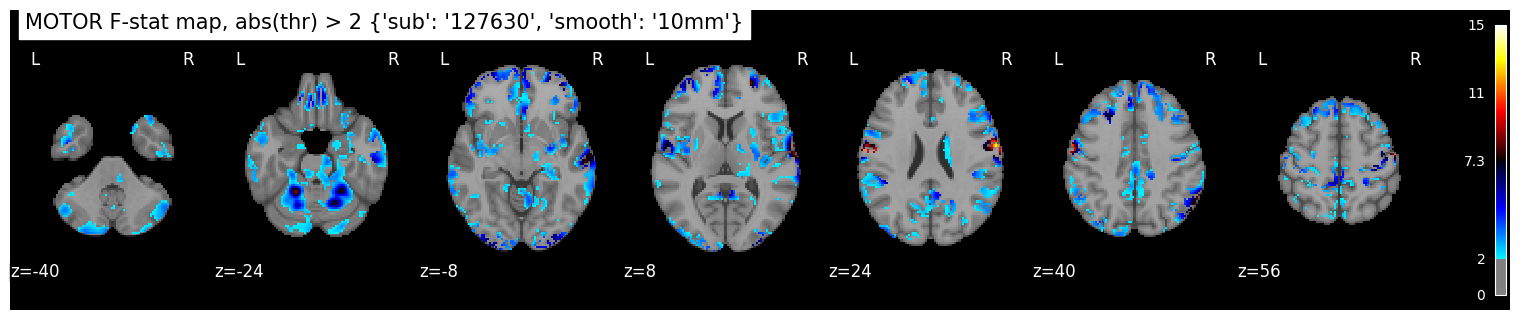

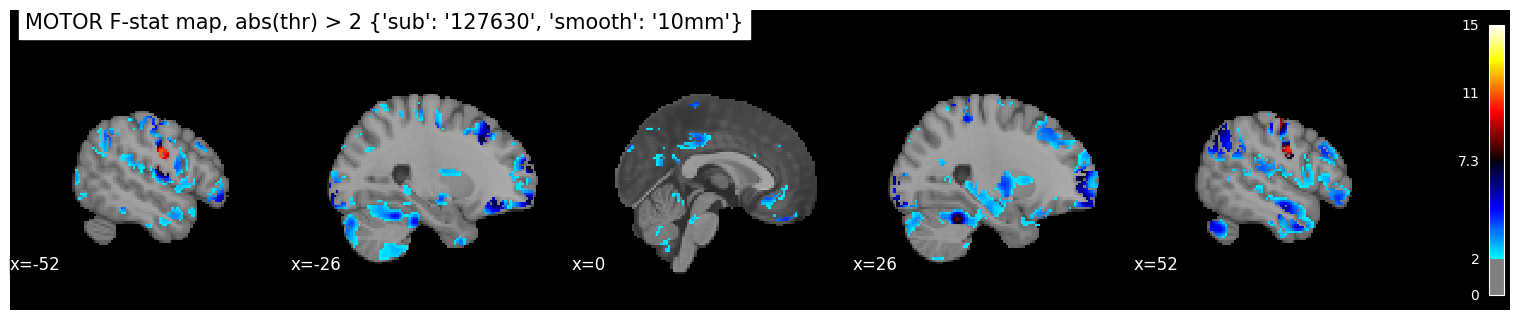

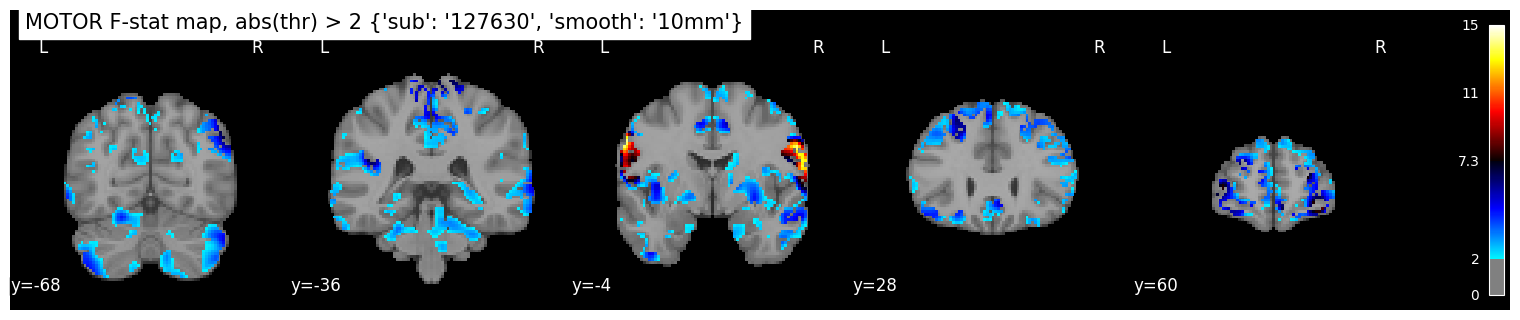

In [10]:
show_task_activation(subject, task, acq, smoothing=smoothing)

/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/127630_gm_mask.nii.gz
concatenating volumes for task MOTOR
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/127630_MOTOR_RL_smooth-10mm_fMRIvols.nii.gz
files 127630_MOTOR_RL_smooth-10mm_fMRIvols.nii.gz already exists, skipping processing
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/127630_Regressor_tfMRI_MOTOR_RL.mat
/media/RCPNAS/Data2/CS-433-ML4S/data/events/127630_MOTOR_RL_event.csv
fitting GLM for task MOTOR


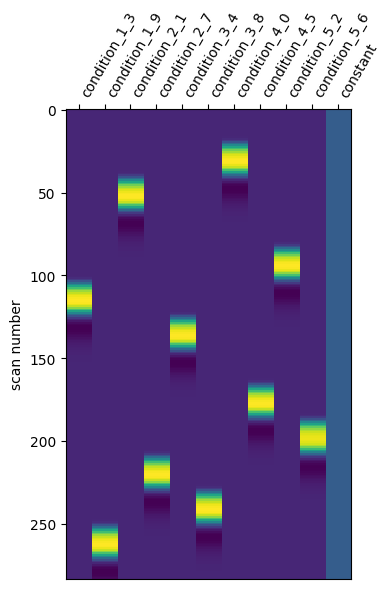

In [5]:
gm_mask = subject_gm_mask_path(subject)
print(gm_mask)

print(f"concatenating volumes for task {task}")
fmri_vols = create_4d_volume(subject, task, acq, smoothing, save=True)

print("processing event conditions")
independent_events = create_events_df(subject, task, acq)

fmri_glm = FirstLevelModel(
    mask_img=gm_mask,
    t_r=TR,
    noise_model="ar1",  # or ols
    standardize=False,
    hrf_model="spm",
    drift_model=None,  # not necessary, nuisance covariates have already been removed
)

# Fit the model to our design and data
print(f"fitting GLM for task {task}")
fmri_glm = fmri_glm.fit(fmri_vols, independent_events)

design_matrix = fmri_glm.design_matrices_[0]

fig, ax = plt.subplots(figsize=(4, 6))
plot_design_matrix(design_matrix, ax=ax)
plt.tight_layout()
plt.show()

n_regressors = design_matrix.shape[1]  # non usato per ora

contrast_matrix = np.diag(np.ones(n_regressors))
contrast_matrix[n_regressors - 1, n_regressors - 1] = 0

contrast_matrix = np.zeros((n_regressors - 1, n_regressors))
np.fill_diagonal(contrast_matrix, 1)  # Identity matrix for joint F-test

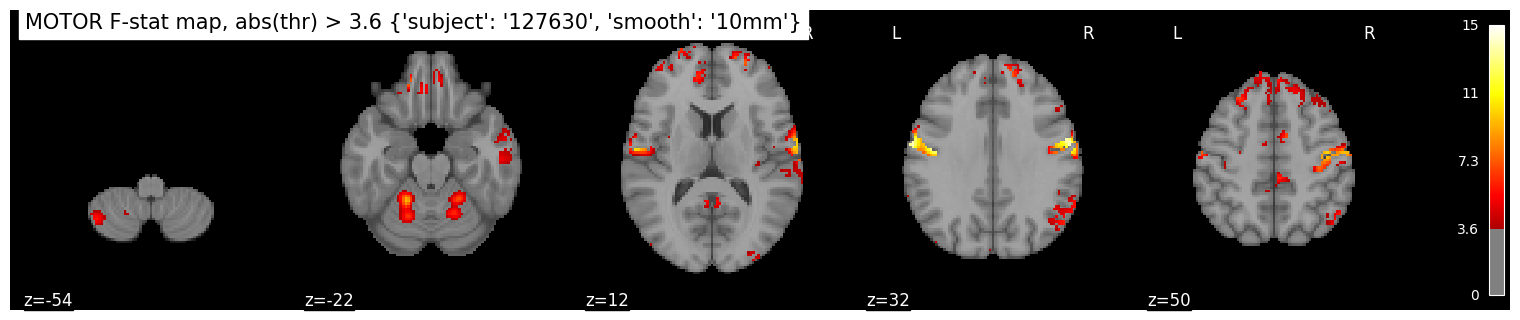

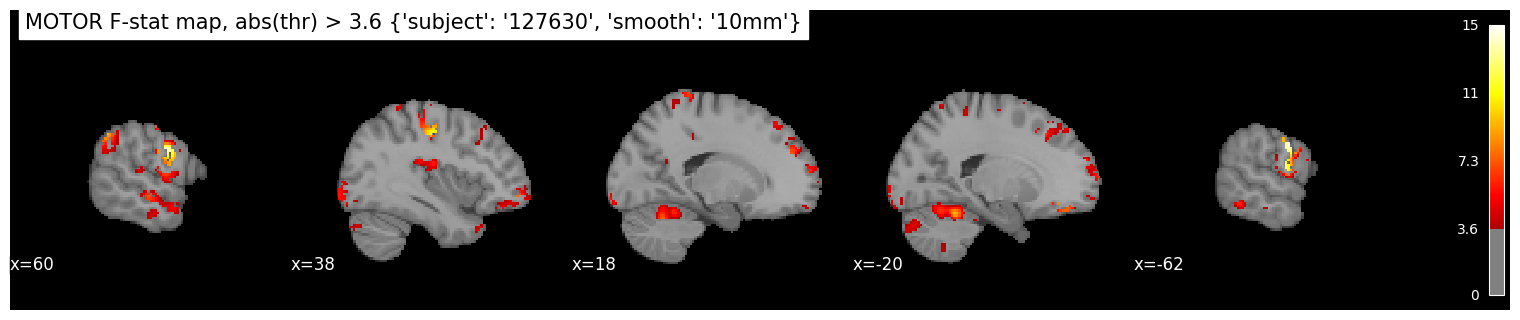

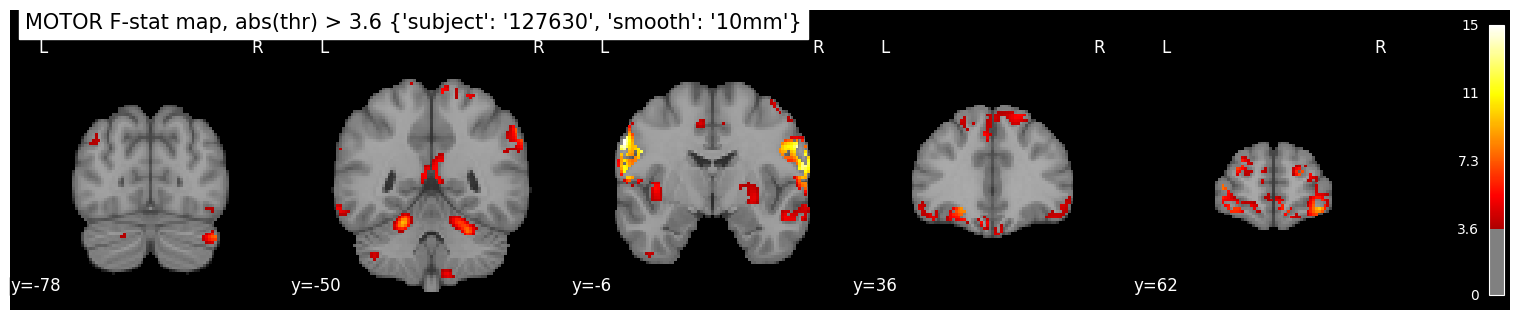

In [7]:
fmap = compute_task_fmap(
    subject, task, acq, smoothing, fmri_glm, contrast_matrix, save=True
)

fmap, threshold = threshold_stats_img(
    fmap, alpha=0.01, cluster_threshold=10
)

info = {"subject": subject, "smooth": f"{smoothing}mm"}
cords = 5
plot_fmap(fmap, 3.6, "z", task=task, info=info, cut_cords=cords)
plot_fmap(fmap, 3.6, "x", task=task, info=info, cut_cords=cords)
plot_fmap(fmap, 3.6, "y", task=task, info=info, cut_cords=cords)

In [8]:
fmap_data = fmap.get_fdata()
fmap.shape

(91, 109, 91)

In [9]:
mask = (fmap_data > threshold)
mask.shape

(91, 109, 91)

In [10]:
fmri_vols.shape

(91, 109, 91, 284)

In [11]:
masked_4d = fmri_vols.get_fdata()[mask]
masked_4d.shape

(21292, 284)

In [12]:
masked_data = fmri_vols.get_fdata()
masked_data[~mask, :] = 0

In [13]:
active_img = nib.Nifti1Image(masked_data, affine=fmri_vols.affine, header=fmri_vols.header)

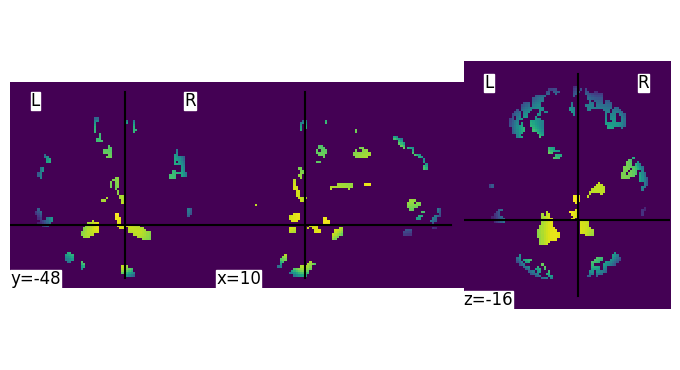

In [14]:
plot_img(image.mean_img(active_img))

In [15]:
plain_design_glm = FirstLevelModel(
    mask_img=gm_mask,
    t_r=TR,
    noise_model="ar1",  # or ols
    standardize=False,
    hrf_model=None,
    drift_model=None, 
    minimize_memory=False,
)

# Fit the model to our design and dRata
print(f"fitting GLM for task {task}")
plain_design_glm = plain_design_glm.fit(active_img, independent_events)

plain_design_matrix = plain_design_glm.design_matrices_[0]

fitting GLM for task MOTOR


/home/federico/venv/lib/python3.13/site-packages/nilearn/glm/first_level/first_level.py:707: UserWarning: Mean values of 0 observed. The data have probably been centered.Scaling might not work as expected
  Y, _ = mean_scaling(Y, self.signal_scaling)


In [16]:
results = plain_design_glm.results_[0]

In [17]:
fmri_vols.shape

(91, 109, 91, 284)

In [18]:
plain_design_glm.residuals[0]

In [19]:
residual_img = plain_design_glm.residuals[0]

In [20]:
predicted = plain_design_glm.predicted[0]
predicted_data = predicted.get_fdata()

In [21]:
predicted_data.shape

(91, 109, 91, 284)

In [22]:
active_img_data = active_img.get_fdata()
active_img_data.shape

(91, 109, 91, 284)

In [ ]:
beta_constrats = plain_design_glm.compute_contrast(contrast_matrix, output_type='effect_size')

In [ ]:
beta_constrats_data = beta_constrats.get_fdata()

/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/127630_Regressor_tfMRI_MOTOR_RL.mat


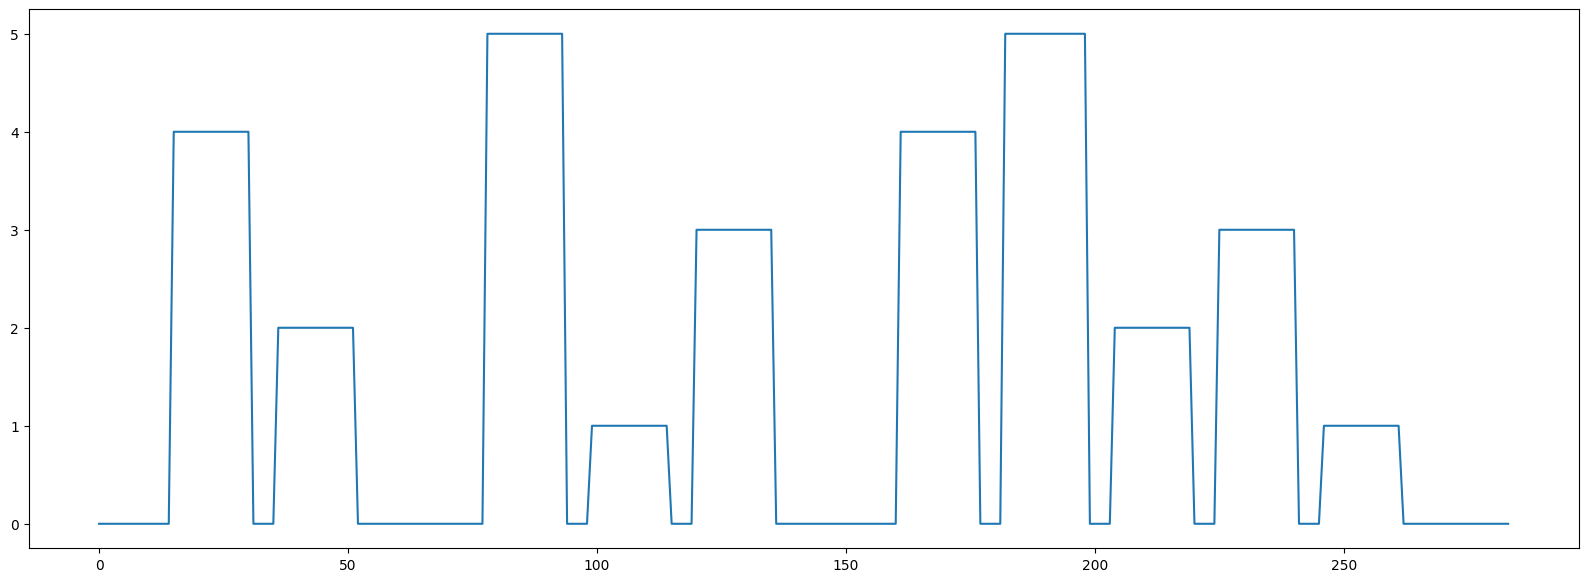

In [23]:
proced_event = processed_event(subject, task, acq)

filepath = pjoin(paradigm_dir, f"{subject}_Regressor_tfMRI_{task}_{acq}.mat")
print(filepath)
data = scipy.io.loadmat(filepath)

regressor = data['Regressor']

# Flatten the regressor to 1D if necessary
regressor_flat = regressor.flatten()

plt.figure(figsize=(20, 7))
plt.plot(regressor_flat)

In [ ]:
voxel_per_dim = 0.8

plt.figure(figsize=(20, 7))
for x in np.random.choice(predicted_data.shape[0], size=int(predicted_data.shape[0] * voxel_per_dim), replace=False):
    for y in np.random.choice(predicted_data.shape[1], size=int(predicted_data.shape[0] * voxel_per_dim), replace=False):
        for z in np.random.choice(predicted_data.shape[2], size=int(predicted_data.shape[0] * voxel_per_dim), replace=False):
            if np.any(np.abs(predicted_data[x, y, z, :]) > 20): 
                continue
            plt.plot(predicted_data[x, y, z, :])

plt.title("Predicted")
plt.xlabel("Time")
plt.show()

In [ ]:
plt.plot(predicted_data[0, 0, 0, :])

In [115]:
betas_dict = {}

for corr_val, reg_result in results.items():
    print(reg_result.predicted.shape)
    betas_dict[corr_val] = reg_result.theta

(284, 39)
(284, 45)
(284, 33)
(284, 24)
(284, 19)
(284, 9)
(284, 11)
(284, 13)
(284, 8)
(284, 11)
(284, 5)
(284, 7)
(284, 3)
(284, 7)
(284, 4)
(284, 4)
(284, 2)
(284, 2)
(284, 1)
(284, 1)
(284, 105)
(284, 58)
(284, 83)
(284, 90)
(284, 95)
(284, 116)
(284, 130)
(284, 138)
(284, 151)
(284, 185)
(284, 207)
(284, 211)
(284, 205)
(284, 245)
(284, 259)
(284, 274)
(284, 284)
(284, 318)
(284, 293)
(284, 281)
(284, 300)
(284, 337)
(284, 304)
(284, 346)
(284, 311)
(284, 387)
(284, 371)
(284, 381)
(284, 372)
(284, 403)
(284, 365)
(284, 378)
(284, 364)
(284, 395)
(284, 433)
(284, 348)
(284, 385)
(284, 420)
(284, 428)
(284, 418)
(284, 418)
(284, 423)
(284, 433)
(284, 412)
(284, 355)
(284, 405)
(284, 362)
(284, 377)
(284, 380)
(284, 295)
(284, 297)
(284, 274)
(284, 267)
(284, 244)
(284, 262)
(284, 240)
(284, 237)
(284, 211)
(284, 217)
(284, 197)
(284, 177)
(284, 160)
(284, 163)
(284, 171)
(284, 148)
(284, 179)
(284, 152)
(284, 155)
(284, 180)
(284, 168)
(284, 178)
(284, 148)
(284, 182)
(284, 185)
(2

<AxesSubplot:label='conditions', ylabel='scan number'>

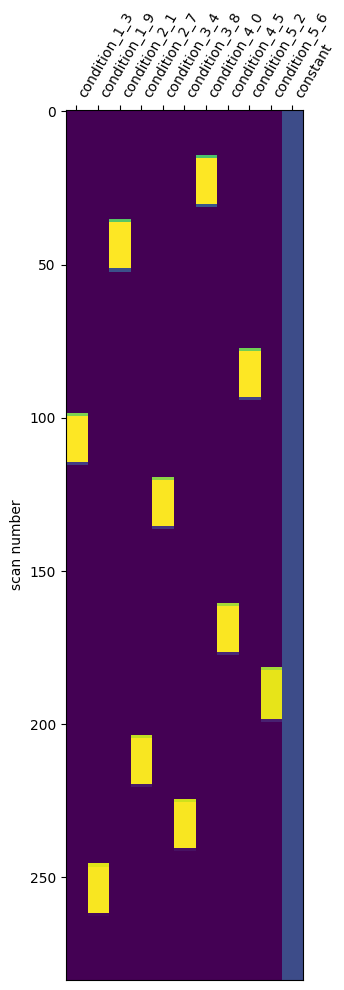

In [104]:
plot_design_matrix(plain_design_matrix)

In [103]:
beta_specific = plain_design_glm.compute_contrast(contrast_matrix) # select all conditions

In [84]:
beta_flat = beta_specific.get_fdata().reshape(-1)
beta_specific.shape

(91, 109, 91)

(array([2.00000e+00, 1.00000e+00, 0.00000e+00, 5.00000e+00, 1.00000e+01,
        1.50000e+01, 2.60000e+01, 5.00000e+01, 4.90000e+01, 6.30000e+01,
        9.00000e+01, 1.11000e+02, 1.21000e+02, 1.25000e+02, 1.55000e+02,
        2.00000e+02, 1.82000e+02, 2.10000e+02, 2.52000e+02, 2.95000e+02,
        3.03000e+02, 3.40000e+02, 3.95000e+02, 3.74000e+02, 8.06182e+05,
        3.89000e+02, 4.25000e+02, 4.12000e+02, 4.62000e+02, 4.65000e+02,
        4.64000e+02, 4.97000e+02, 4.92000e+02, 5.45000e+02, 4.91000e+02,
        5.00000e+02, 5.25000e+02, 5.29000e+02, 5.63000e+02, 5.28000e+02,
        5.15000e+02, 5.10000e+02, 5.24000e+02, 4.57000e+02, 4.41000e+02,
        4.20000e+02, 4.38000e+02, 3.76000e+02, 3.68000e+02, 3.42000e+02,
        3.07000e+02, 3.15000e+02, 2.98000e+02, 2.69000e+02, 2.74000e+02,
        2.40000e+02, 2.67000e+02, 2.46000e+02, 2.54000e+02, 2.44000e+02,
        2.55000e+02, 2.35000e+02, 2.18000e+02, 2.21000e+02, 2.13000e+02,
        2.04000e+02, 2.05000e+02, 1.64000e+02, 1.79

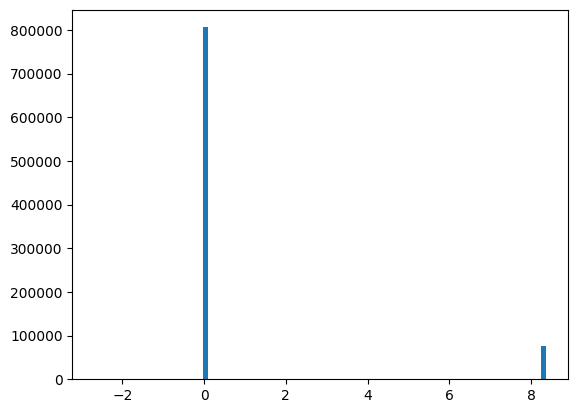

In [96]:
plt.hist(beta_flat, bins=100)

In [100]:
vals, count = np.unique(beta_flat, return_counts=True)

(array([2.0907e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

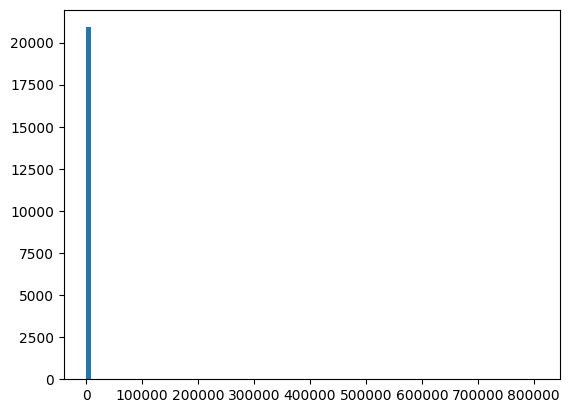

In [102]:
plt.hist(count, bins=100)

# F vs t contrast

In [28]:
def plot_fmap(fmap, threshold, display_mode, task="", info=None, cut_cords=7):
    plot_stat_map(
        fmap,
        threshold=threshold,
        title=f"{task} F-stat map, abs(thr) > {threshold} {info}",
        figure=plt.figure(figsize=(15, 3)),
        display_mode=display_mode,
        cut_coords=cut_cords,
        black_bg=True,
        colorbar=True
    )

selecting subject gray matter mask
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/127630_gm_mask.nii.gz
concatenating volumes for task MOTOR
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/127630_MOTOR_RL_smooth-10mm_fMRIvols.nii.gz
files 127630_MOTOR_RL_smooth-10mm_fMRIvols.nii.gz already exists, skipping processing
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/127630_Regressor_tfMRI_MOTOR_RL.mat
/media/RCPNAS/Data2/CS-433-ML4S/data/events/127630_MOTOR_RL_event.csv
fitting GLM for task MOTOR
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
computing fmap


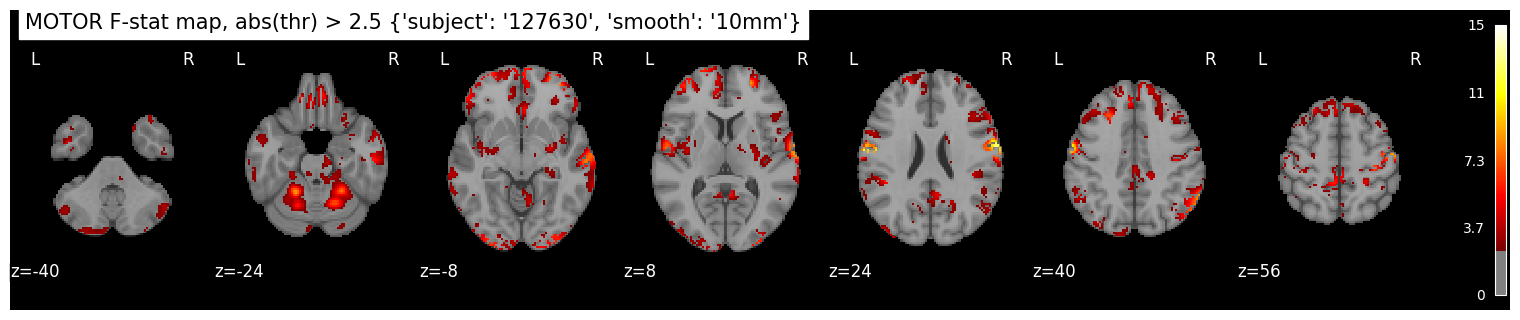

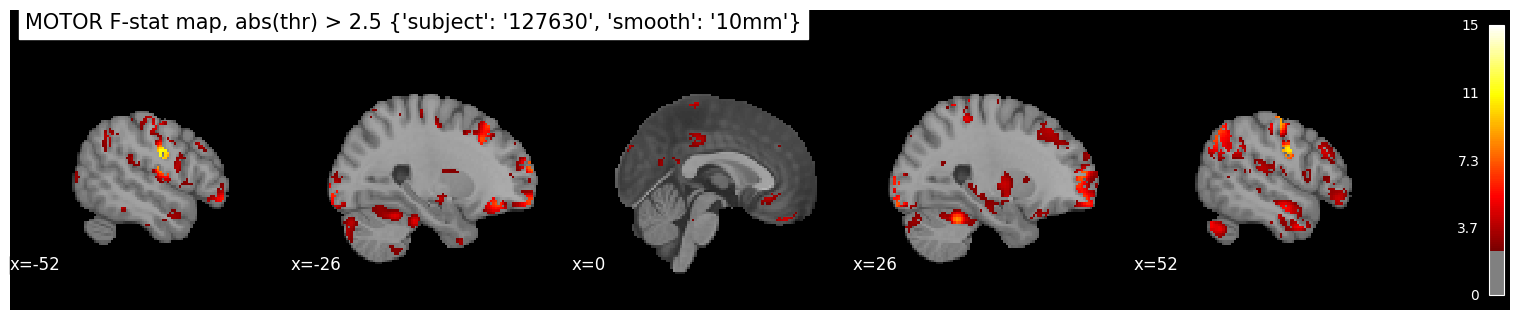

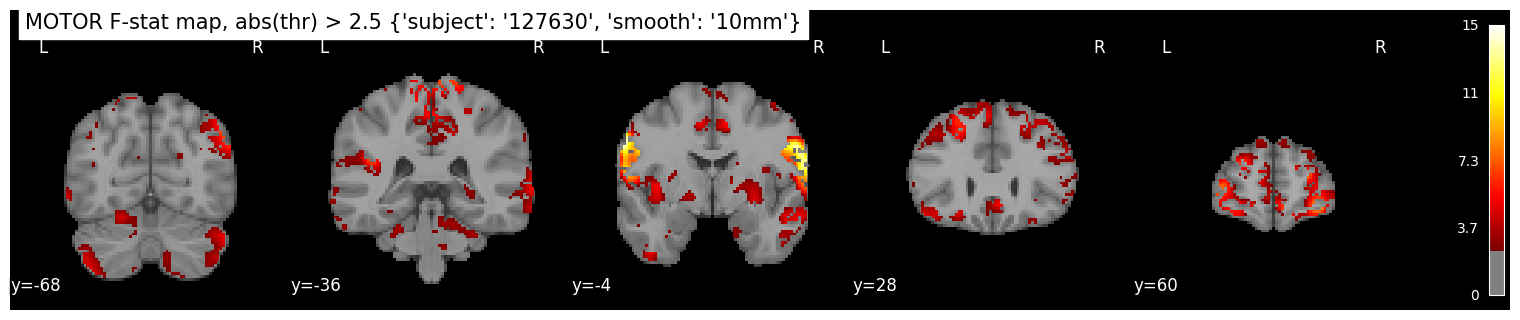

In [39]:
x_coords = [-52, -26, 0, 26, 52]  # Left to right
y_coords = [-68, -36, -4, 28, 60]  # Posterior to anterior
z_coords = [-40, -24, -8, 8, 24, 40, 56]  # Inferior to superior

acquisition = acq
threshold = 2.5

print("selecting subject gray matter mask")
gm_mask = subject_gm_mask_path(subject)
print(gm_mask)

print(f"concatenating volumes for task {task}")
fmri_vols = create_4d_volume(subject, task, acquisition, smoothing, save=True)

print("processing event conditions")
independent_events = create_events_df(subject, task, acquisition)

fmri_glm = FirstLevelModel(
    mask_img=gm_mask,
    t_r=TR,
    noise_model='ar1', # or ols 
    standardize=False,
    hrf_model='spm',
    drift_model=None, # not necessary, nuisance covariates have already been removed
)

# Fit the model to our design and data
print(f"fitting GLM for task {task}")
fmri_glm = fmri_glm.fit(fmri_vols, independent_events)

design_matrix = fmri_glm.design_matrices_[0]
#fig, ax = plt.subplots(figsize=(4, 6))
#plot_design_matrix(design_matrix, ax=ax)
#plt.tight_layout()
#plt.show()

n_regressors = design_matrix.shape[1] #non usato per ora

contrast_matrix = np.diag(np.ones(n_regressors)) 
contrast_matrix[n_regressors-1, n_regressors-1] = 0 

contrast_matrix = np.zeros((n_regressors-1, n_regressors))

np.fill_diagonal(contrast_matrix, 1)  # Identity matrix for joint F-test

print(contrast_matrix)

print("computing fmap")

fmap = fmri_glm.compute_contrast(contrast_matrix, stat_type='F', output_type='stat')

#if cluster_size is not None:
#    fmap, threshold = threshold_stats_img(fmap, alpha=fdr_rate, cluster_threshold=cluster_size)

info = {"subject": subject, "smooth": f"{smoothing}mm"}
plot_fmap(fmap, threshold, "z", task=task, info=info, cut_cords=z_coords)
plot_fmap(fmap, threshold, "x", task=task, info=info, cut_cords=x_coords)
plot_fmap(fmap, threshold, "y", task=task, info=info, cut_cords=y_coords)
plt.show()

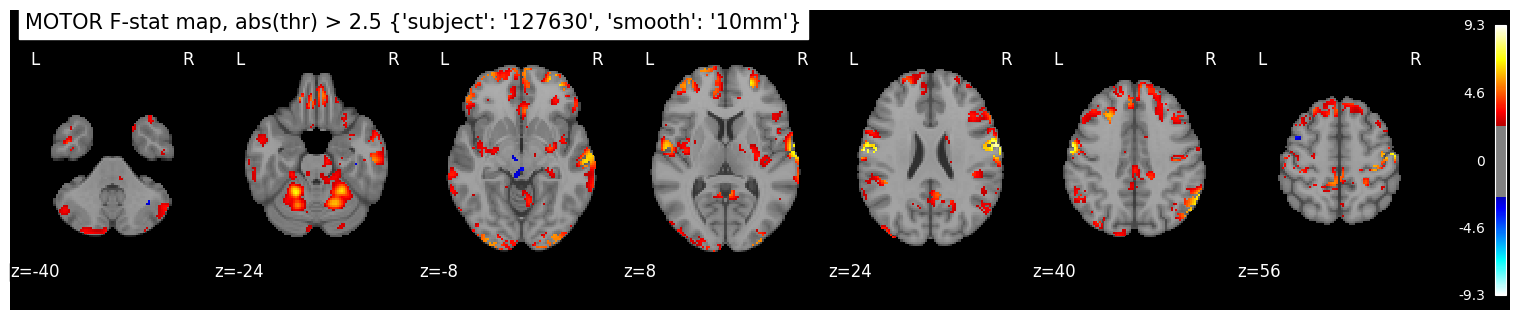

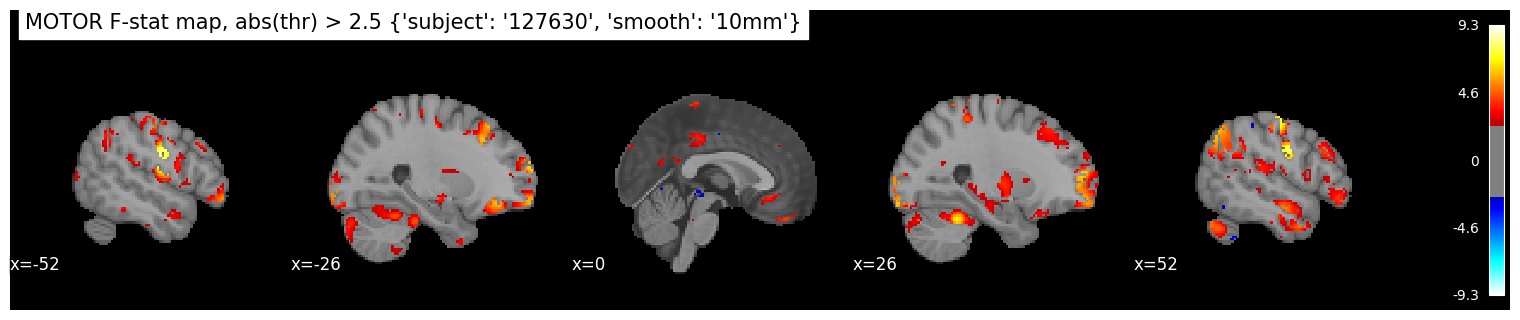

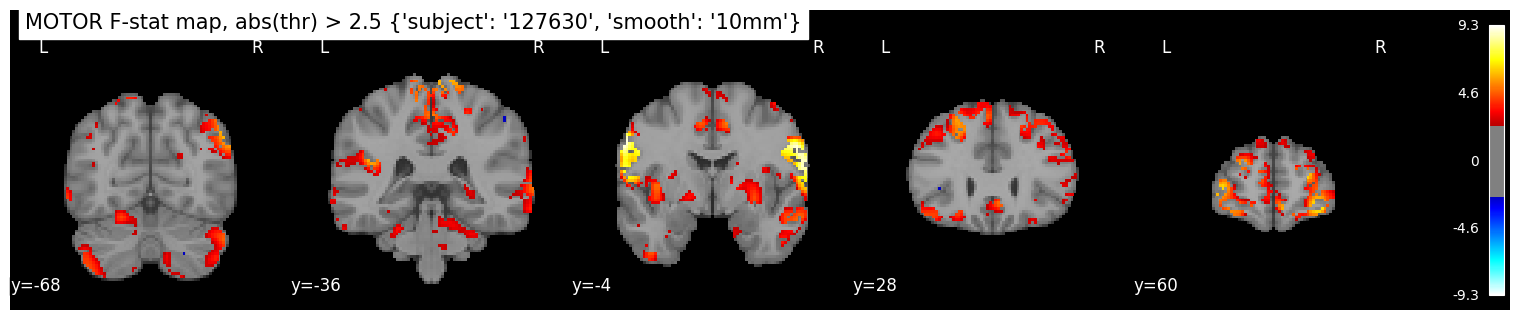

In [43]:
fmap_zscore = fmri_glm.compute_contrast(contrast_matrix, stat_type='F')

#if cluster_size is not None:
#    fmap, threshold = threshold_stats_img(fmap, alpha=fdr_rate, cluster_threshold=cluster_size)

info = {"subject": subject, "smooth": f"{smoothing}mm"}
plot_fmap(fmap_zscore, threshold, "z", task=task, info=info, cut_cords=z_coords)
plot_fmap(fmap_zscore, threshold, "x", task=task, info=info, cut_cords=x_coords)
plot_fmap(fmap_zscore, threshold, "y", task=task, info=info, cut_cords=y_coords)
plt.show()

In [44]:
print("F-map stats:")
print(f"Min: {fmap_zscore.get_fdata().min()}")
print(f"Max: {fmap_zscore.get_fdata().max()}")
print(f"Mean: {fmap_zscore.get_fdata().mean()}")

F-map stats:
Min: -3.8713370387861454
Max: 9.287380163544478
Mean: 0.1531658975962822


In [38]:
print("Design matrix shape:", design_matrix.shape)
print("Contrast matrix shape:", contrast_matrix.shape)

# Also let's look at a sample of the contrast matrix
print("Contrast matrix first few rows:")
print(contrast_matrix[:5])

Design matrix shape: (284, 11)
Contrast matrix shape: (10, 11)
Contrast matrix first few rows:
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


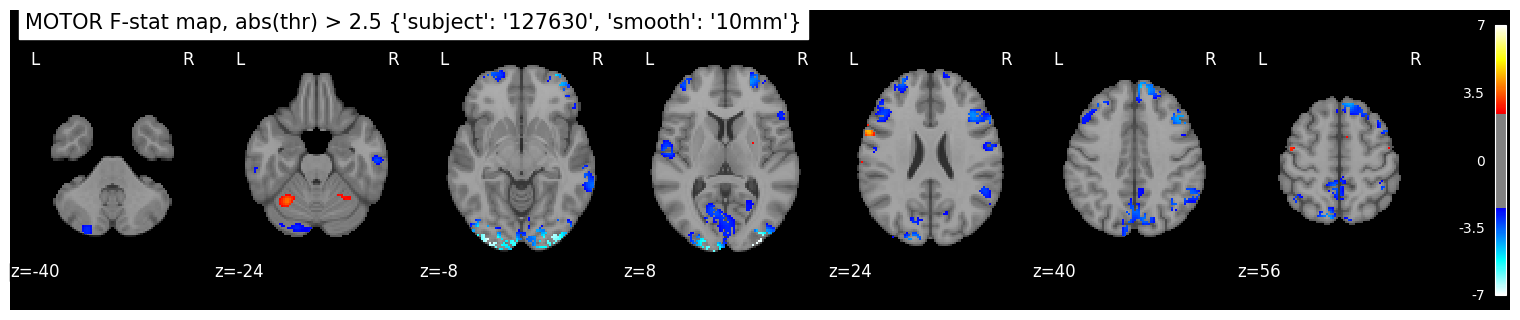

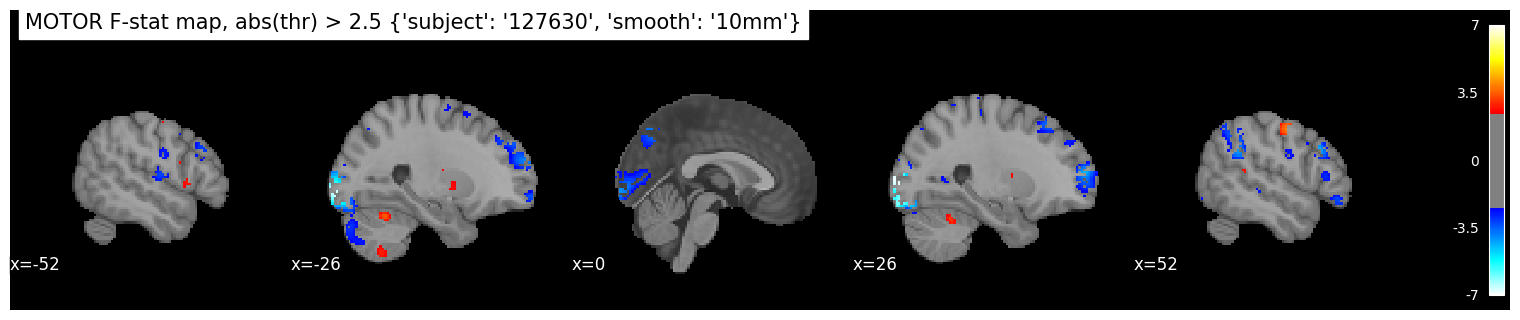

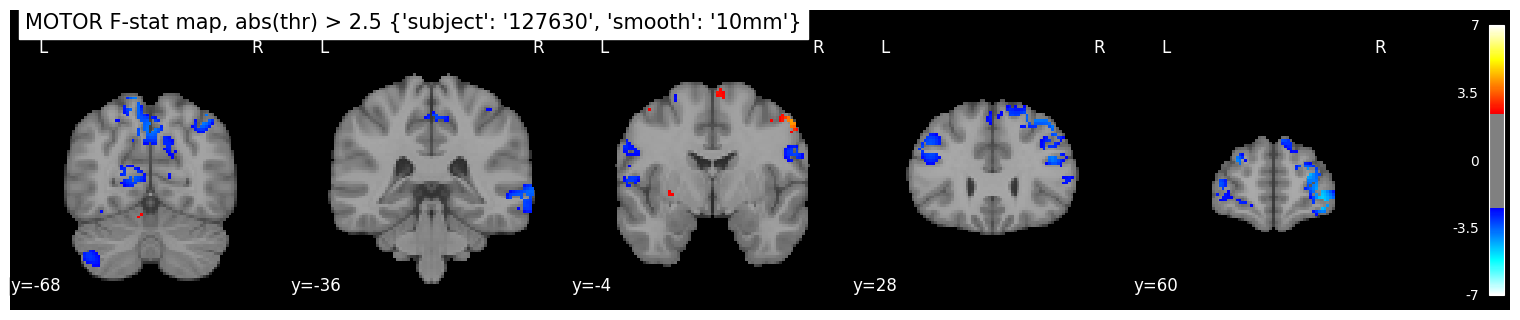

In [35]:
tmap = fmri_glm.compute_contrast(np.ones(contrast_matrix.shape[1]), stat_type='t')

#if cluster_size is not None:
#    fmap, threshold = threshold_stats_img(fmap, alpha=fdr_rate, cluster_threshold=cluster_size)

plot_fmap(tmap, threshold, "z", task=task, info=info, cut_cords=z_coords)
plot_fmap(tmap, threshold, "x", task=task, info=info, cut_cords=x_coords)
plot_fmap(tmap, threshold, "y", task=task, info=info, cut_cords=y_coords)
plt.show()

In [32]:
contrast_matrix = np.eye(n_regressors)
contrast_matrix

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

- stratified x-val across subjects
- CUDA toolkit